# L3: Function Approximation and Interpolation

In Economics, many times we want to evaluate a function $f(x)$ at a given point $x$, but this function may be hard to compute. Today we will consider the following problem: Based on its values on a grid $f(x_i)$ for $x_1 \leq x_2 \leq \cdots \leq x_n$, can we approximate $f(x)$ for an arbitrary point $x \in [x_1, x_n]$? The first section in these lecture notes is a good example of when function approximation/interpolation is useful to gain computational efficiency without sacrificing accuracy.

## 1. Motivation: A Simple Dynamic Programming Problem
For this lecture, we will be working with a very simple cake-eating problem. Consider the following environment:
- Time is discrete and the horizon is infinite: $t = 0, 1, 2, \ldots$
- A single agent is endowed with an initial amount of cake $x_0$. At each period $t \geq 0$, the agent decides how much cake to eat $c_t \in [0, x_t]$. 
- The amount of cake left $x_t$ evolves according to $x_{t+1} = x_t - c_t$.
- The value function for this problem is: 
\begin{align}
V^*(x) = \max_{\{c_t\}_{t=0}^\infty} & \sum_{t=0}^\infty \beta^t u(c_t) \\
\text{subj. to } & 0 \leq c_t \leq x_t \\ & x_{t+1} = x_t - c_t \\ & x_0 = x
\end{align}

- As you know from 14.451, the value function solves the Bellman equation:
$$V^*(x) = \max_{0 \leq c \leq x}\{u(c) + \beta V^*(x - c)\}$$ 
and can be found by Bellman iteration:
$$V^{(k+1)}(x) = \max_{0 \leq c \leq x}\{u(c) + \beta V^{(k)}(x - c)\} \quad \text{for $k = 0, 1, \ldots$ until convergence.}$$ 

We will work with the simple case of $u(c) = \log(c)$, in which case we know the analytical solution, which we can use to determine accuracy:

$$V^*(x) = \frac{\log(x)}{1 - \beta} + \frac{\log(1-\beta)}{1-\beta} + \frac{\beta \log(\beta)}{(1-\beta)^2} \quad \text{and} \quad c^*(x) = (1 - \beta)x$$

(You can check that this is correct using a guess-and-verify method: Plug $V(x) = A \log(x) + B$ in the Bellman equation, compute the maximum of the RHS and solve for $A$ and $B$ by matching the terms on the LHS and the RHS.) 

And although here we know the closed-form solution, in many practical cases this will be hard or impossible to obtain, making the methods introduced in this lecture even more important!

### 1.1. Solving the Bellman equation on a grid
Notice that the Bellman equation is a functional equation (the unknown is a function!). We can't do Bellman iteration for each possible $x$, because there are uncountably many values that $x$ could take. 

Instead, we could discretize the space where $x$ lives in a grid $x_1 \leq x_2 \leq \cdots \leq x_n$ and try to solve the $n$ equations:

$$V(x_i) = \max_{0 \leq c \leq x_i}\{u(c) + \beta V(x_i - c)\} \quad i = 1, \ldots, n$$

The problem is that, inside the maximization in the RHS, $c$ is still a continuous variable, and we need to evaluate $V(x_i - c)$ at a point outside the grid. One easy fix is to restrict $x_i - c$ to take values in the same grid as well, so that $c = x_i - x_j$ for some $1 \leq j \leq i$. In that case we can do:

$$V(x_i) = \max_{j \in \{1, \ldots, i\}}\{u(x_i - x_j) + \beta V(x_j)\} \quad i = 1, \ldots, n$$

The RHS corresponds to finding the largest element in a vector, so it can be done relatively fast with the function ```findmax```.

Let's try to implement Bellman iteration based on discretization in Julia!

In [10]:
# using LinearAlgebra

u(c::Float64) = log(c)

# RHS of the Bellman eq.
function Bellman(x_grid::AbstractRange{Float64}, v_grid::Vector{Float64}; β = 0.9)
    # Input:
    # x_grid = range(xmin, xmax, length) : a grid for the x values
    # v_grid : the corresponding grid for V(x) values
    
    # Output:
    # v_next : the RHS of the Bellman eq. for each x on the grid
    # c_max : the policy function for each x on the grid corresponding to v_grid
    
    # Initialize empty vectors to store the results
    v_next = zero(v_grid)
    c_max = zero(v_grid)
    
    for (i, x) in enumerate(x_grid)
        v_next[i], max_ind = findmax(u(x_grid[i]-x_grid[j]+1e-5) + β*v_grid[j] for j in 1:i) 
        # Above we add small number 1e-5 to avoid log(0)
        c_max[i] = x_grid[i] - x_grid[max_ind]
    end
    return v_next, c_max
end

# Solve Bellman eq. by iteration
function Bellman_iter(x_grid::AbstractRange{Float64}; β = 0.9, tol = 1e-10)
    # Input:
    # x_grid = range(xmin, xmax, length) : a grid for the x values
    
    # Output:
    # v_star : the value function for each x on the grid
    # c_max : the policy function for each x on the grid
    
    # Initialize empty vectors to store the results
    v_grid = zero(x_grid)
    v_next = zero(x_grid)
    c_max = zero(x_grid)
    
    error = 1000.0

    while error > tol
        v_next, c_max = Bellman(x_grid, v_grid; β)
        error = maximum(abs.(v_next .- v_grid))
        v_grid = v_next
    end
    
    return v_next, c_max
end

x0 = 10
x_grid = range(0, x0, length=100)

@time v_grid, c_grid = Bellman_iter(x_grid);

  0.098296 seconds (333.65 k allocations: 18.055 MiB, 84.11% compilation time)


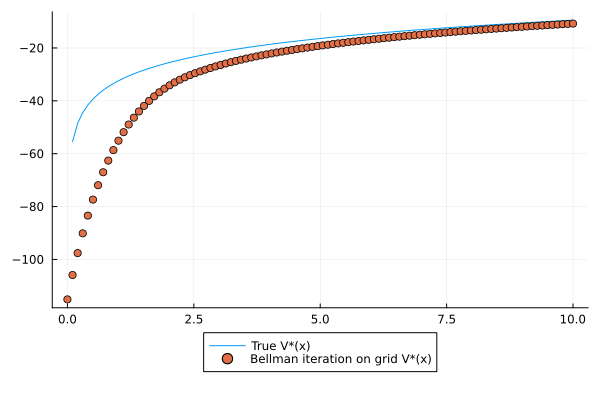

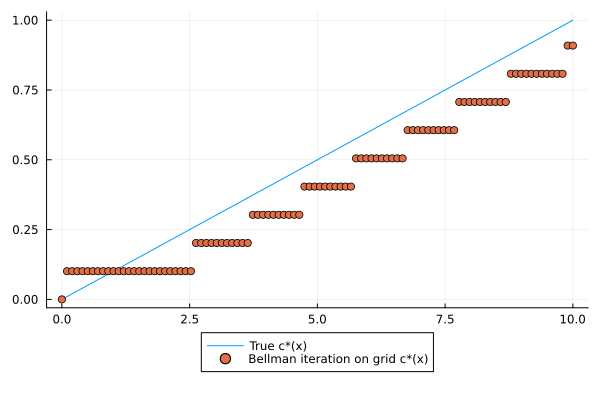

In [11]:
using Plots

V_true(x; β = 0.9) = log(x)/(1.0 - β) + log(1.0 - β)/(1.0 - β) + β*log(β) / (1.0 - β)^2

plot_grid = range(x_grid[1], x_grid[end], length=100) # Finer grid for plot

gr()
plot(plot_grid, V_true.(plot_grid), label = "True V*(x)", legend = :outerbottom)
display(plot!(scatter!(x_grid, v_grid, label = "Bellman iteration on grid V*(x)")))

c_true(x; β = 0.9) = (1.0 - β) * x

gr()
plot(plot_grid, c_true.(plot_grid), label = "True c*(x)", legend = :outerbottom)
display(plot!(scatter!(x_grid, c_grid, label = "Bellman iteration on grid c*(x)")))

This is pretty bad! In fact, if we want accuracy with this method, we need to use a very fine grid (which is very time- and memory-consuming):

In [12]:
x_grid = range(0, x0, length=1000)

@time v_grid, c_grid = Bellman_iter(x_grid);

gr()
plot(plot_grid, V_true.(plot_grid), label = "True V*(x)", legend = :outerbottom)
display(plot!(scatter!(x_grid, v_grid, label = "Bellman iteration on grid V*(x)")))

gr()
plot(plot_grid, c_true.(plot_grid), label = "True c*(x)", legend = :outerbottom)
display(plot!(scatter!(x_grid, c_grid, label = "Bellman iteration on grid c*(x)")))

  1.480059 seconds (2.20 k allocations: 5.674 MiB, 0.28% gc time)


Idea: can we do better if we have a small grid, but inside the RHS of Bellman equation:

$$V(x_i) = \max_{0 \leq c \leq x_i}\{u(c) + \beta V(x_i - c)\} \quad i = 1, \ldots, n$$

we replace $V$ by an approximation $\tilde{V}$ that can be evaluated at a continuum of points?

## 2. Functional Approximation and Interpolation
The previous section motivates the followign problem: We have a function $f(x)$ which is hard to compute. Based on its values on a grid $f(x_i)$ for $i = 1, \ldots, n$, can we approximate $f(x)$ for an arbitrary point $x \in [x_1, x_n]$?

Remarks:
1. Function approximation is different from regression. When we estimate a regression, we assume our data has noise, so we may want to limit the complexity of the model to avoid over-fitting the data (i.e. capturing noise rather than the features we are interested in). In contrast, here we want to match the data as closely as possible, in most cases, by **interpolating** (i.e. matching the known values at our set of points exactly).
2. **Extrapolating** refers to computing the approximated function outside of the original data interval. In general, this should be avoided unless the properties of the function that is being approximated are well-understood (i.e. we know for sure it is a quadratic polynomial). Instead, try to introduce wider bounds for the grid on which the approximation is based.

We will be using the ```BasicInterpolators``` package in Julia.

In [13]:
using BasicInterpolators

### 2.1. Piece-wise interpolators
The simplest interpolation method we can think of is a simple "connect the dots." That can be achieved with ```LinearInterpolator``` in ```BasicInterpolators```:

In [14]:
approx_grid = range(0.1, x0, 5)
plot_grid = range(0.1, x0, length=100)

lin_int = LinearInterpolator(approx_grid, V_true.(approx_grid))

plot(plot_grid, V_true.(plot_grid), label = "True V(x)", linestyle = :dash, legend = :outerbottom)
plot!(scatter!(approx_grid, V_true.(approx_grid), label = "True V(x) on grid"))
plot!(plot_grid, lin_int.(plot_grid), label = "Piecewise linear interpolation")

Obviously, if the function is very far from linear (e.g. between the first two points), this interpolation is very bad. An option is to use piecewise polynomials of higher order (e.g. piecewise cubic). However, this does not guarantee smoothness at the nodes. That's how splines came about:

### 2.2. Splines
A **spline** $s(x)$ of order $n$ (or degree $n-1$) is a function on $[a,b]$ such that:
1. Given _knot_ points $a = x_1 < \cdots < x_n = b$, $s(x)$ is a polynomial of degree $n-1$ inside each sub-interval $(x_i, x_{i+1})$ for $i = 1, \ldots, n-1$
2. $s(x)$ has continuous derivatives of order up to $n-2$ at the knots (and of any order between the knots, since it is a polynomial)

So, basically, it is a piecewise polynomial with smoothness enforced at the nods.

A very important example are **cubic splines**:
1. The functional form is $s(x) = a_i + b_i x + c_i x^2 + d_i x^3$ on $(x_i, x_{i+1})$ for $i = 1, \ldots, n-1$. Hence, there are $4(n-1)$ unknown coefficients
2. There are $2(n-1)$ equations making sure that each segment passes through its end-points, and $2(n-2)$ equations to ensure two continuous derivatives at all interior knots $x_2, \ldots, x_{n-1}$
3. The remaining 2 equations are boundary conditions for the end-points $x_1$ and $x_n$. A common approach is the _natural_ spline, that imposes $s''(x_1) = s''(x_n) = 0$.

Let's look how a ```CubicSplineInterpolator``` from ```BasicInterpolators``` would look like in our setting:

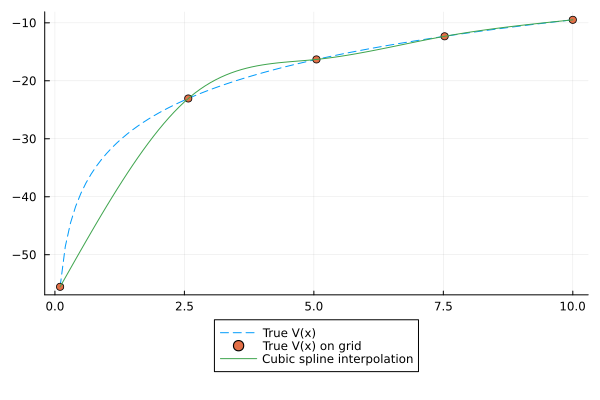

In [15]:
cub_spline_int = CubicSplineInterpolator(approx_grid, V_true.(approx_grid))

plot(plot_grid, V_true.(plot_grid), label = "True V(x)", linestyle = :dash, legend = :outerbottom)
plot!(scatter!(approx_grid, V_true.(approx_grid), label = "True V(x) on grid"))
plot!(plot_grid, cub_spline_int.(plot_grid), label = "Cubic spline interpolation")

For a given sequence of knots, the space of splines has a set of basis functions called **B-splines**. These are defined recursively as:
$$B_{i,1}(x) = \begin{cases}1 & \quad \text{if } x_i \leq x < x_{i+1} \\ 0 & \quad \text{otherwise}\end{cases}$$ and, for higher degree $k \geq 1$: 
$$B_{i,k+1}(x) = \frac{x - x_i}{x_{i+k} - x_i}B_{i,k}(x) + \frac{x_{i+k+1} - x}{x_{i+k+1} - x_{i+1}}B_{i+1,k}(x).$$

Because B-splines form a basis of the space of splines, any polynomial spline (including the cubic spline above) can be expressed as a linear combination of B-splines. 

More importantly, B-splines allow you to do much more, such as imposing shape constraints. For example, the package ```Interpolations``` has a series of algorithms that compute monotonic cubic B-spline interpolations:

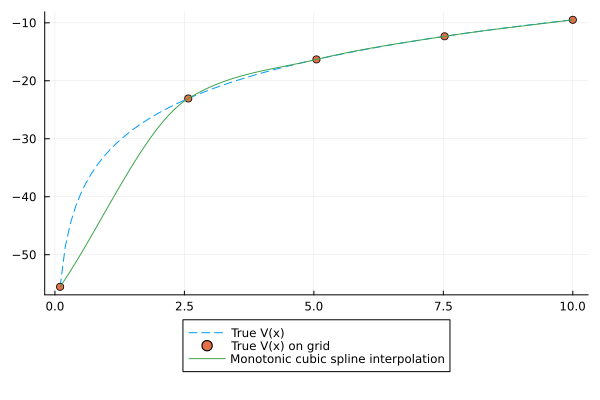

In [16]:
using Interpolations

# Notice that the Interpolations syntax below is a bit different from BasicInterpolators:
mono_spline_int = interpolate(approx_grid, V_true.(approx_grid), SteffenMonotonicInterpolation())

plot(plot_grid, V_true.(plot_grid), label = "True V(x)", linestyle = :dash, legend = :outerbottom)
plot!(scatter!(approx_grid, V_true.(approx_grid), label = "True V(x) on grid"))
plot!(plot_grid, mono_spline_int.(plot_grid), label = "Monotonic cubic spline interpolation")

### 2.3. Neville's algorithm
Another possibility to interpolate $n$ data points is to fit a polynomial of degree $n-1$. This can be done fast using [Neville's algorithm](https://en.wikipedia.org/wiki/Neville%27s_algorithm). The algorithm works by computing lower degree polynomials (i.e. the degree-0 polynomial that goes through one point, the degree-1 polynomial that goes through two points, and so forth). These lower-degree polynomials are then combined recursively with a given (known) set of weights.

```BasicInterpolators``` has a function called ```neville``` to do polynomial interpolation with Neville's algorithm, and it works in a simple way:

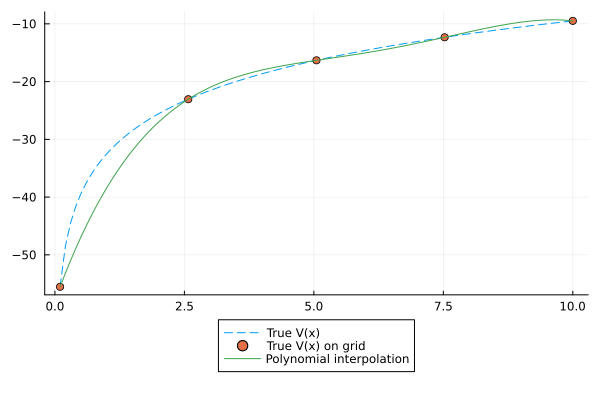

In [17]:
nev_int(x) = neville(x, approx_grid, V_true.(approx_grid))

plot(plot_grid, V_true.(plot_grid), label = "True V(x)", linestyle = :dash, legend = :outerbottom)
plot!(scatter!(approx_grid, V_true.(approx_grid), label = "True V(x) on grid"))
plot!(plot_grid, nev_int.(plot_grid), label = "Polynomial interpolation")

### 2.4. Chebyshev's interpolation
Chebyshev polynomials (of the first kind) are a sequence of polynomials on $[-1,1]$. They can be defined recursively as: $T_0(x) = 1$, $T_1(x) = x$, $T_{n+1}(x) = 2xT_n(x) - T_{n-1}(x)$, or in closed form as $T_n(x) = \cos(n \cos^{-1}(x))$.

The zeros of Chebyshev's polynomials are very important in approximation theory. It can be shown the $(n - 1)$-degree polynomial interpolation where the data points are at the zeros of $T_n(x)$ achieves the best polynomial approximation with respect to the uniform norm.

Typically, polynomial interpolation with equally spaced data will result in large oscillations towards the boundaries, and the problem only gets worse as the degree increases. Chebyshev interpolation solves this problem. One caveat is that it doesn't approximate the gradient $f'(x)$ well.

In ```BasicInterpolators```, the Chebyshev nodes can be computed with ```chebygrid```, and then we use ```ChebyshevInterpolator``` to get the polynomial interpolation at those points.

In [18]:
cheb_grid = chebygrid(0.1, x0, 5)
cheb_int = ChebyshevInterpolator(cheb_grid, V_true.(cheb_grid))

plot(plot_grid, V_true.(plot_grid), label = "True V(x)", linestyle = :dash, legend = :outerbottom)
plot!(scatter!(cheb_grid, V_true.(cheb_grid), label = "True V(x) on grid"))
plot!(plot_grid, cheb_int.(plot_grid), label = "Chebyshev interpolation")

### 2.5. Comparison
Let's finish by comparing the error $|f(x) - I(x)|$ of our different interpolators $I(x)$:

In [19]:
error(x, interp) = abs(V_true(x) - interp(x))

plot(plot_grid, error.(plot_grid, (lin_int,)), label = "Piecewise linear interpolation")
plot!(plot_grid, error.(plot_grid, (cub_spline_int,)), label = "Cubic spline interpolation")
plot!(plot_grid, error.(plot_grid, (mono_spline_int,)), label = "Monotonic cubic spline interpolation")
plot!(plot_grid, error.(plot_grid, (nev_int,)), label = "Polynomial interpolation")
plot!(plot_grid, error.(plot_grid, (cheb_int,)), label = "Chebyshev interpolation")

As expected, Chebyshev does well in a uniform sense, i.e. $\sup_{x} |f(x) - I(x)|$ is smaller than for other interpolation methods. Between the second and last knots, the monotonic cubic B-spline does best. The simple "connect the dots" piecewise linear interpolation does surprisingly well for most of the domain, since $f(x)$ is not far from linear in those regions.

Another interesting question is how the error changes with the number of data points. To answer that, we can look at two measures that summarize the error over the function domain:
$$\Vert f - I \Vert_{1} = \int_0^{x_0} |f(x) - I(x)|\mathrm{d}x \quad \text{and} \quad \Vert f - I \Vert_{\infty} = \sup_{0\leq x\leq x_0} |f(x) - I(x)|.$$

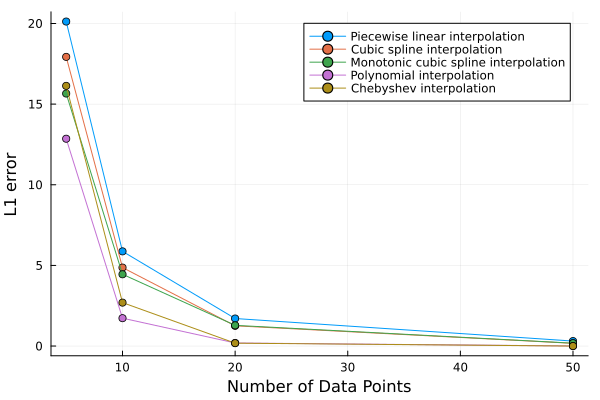

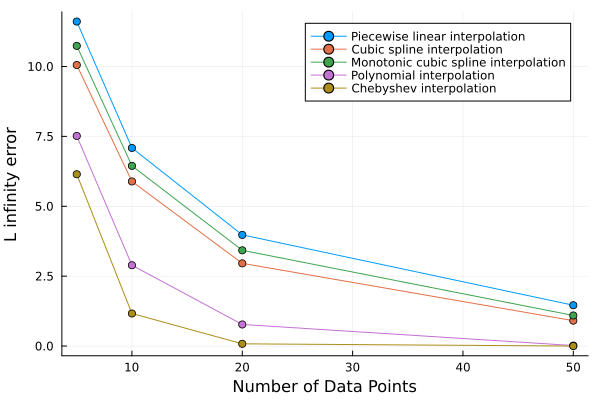

In [13]:
using QuadGK # Package for numerical integration, we'll learn about it in next lecture

function error_as_fn_of_n(ns::Vector{Int64})
    
    L1 = zeros(Float64, length(ns), 5)
    Linf = zeros(Float64, length(ns), 5)
    
    for (ind1, n) in enumerate(ns)
        approx_grid = range(0.1, x0, n)
        cheb_grid = chebygrid(0.1, x0, n)

        lin_int = LinearInterpolator(approx_grid, V_true.(approx_grid))
        cub_spline_int = CubicSplineInterpolator(approx_grid, V_true.(approx_grid))
        mono_spline_int = interpolate(approx_grid, V_true.(approx_grid), SteffenMonotonicInterpolation())
        nev_int(x) = neville(x, approx_grid, V_true.(approx_grid))
        cheb_int = ChebyshevInterpolator(cheb_grid, V_true.(cheb_grid))


        for (ind2, int) in enumerate([lin_int, cub_spline_int, mono_spline_int, nev_int, cheb_int])
            Linf[ind1, ind2] = maximum(error.(plot_grid, (int,)))
            L1[ind1, ind2], _ = quadgk(x -> error(x, int), 0.1, x0)
        end
    end
    
    return L1, Linf
end 

L1, Linf = error_as_fn_of_n([5, 10, 20, 50])

labels = ["Piecewise linear interpolation" "Cubic spline interpolation" "Monotonic cubic spline interpolation" "Polynomial interpolation" "Chebyshev interpolation"]
gr()
display(plot([5, 10, 20, 50], L1, label = labels, markershape = :circle, xlabel = "Number of Data Points", ylabel = "L1 error"))
display(plot([5, 10, 20, 50], Linf, label = labels, markershape = :circle, xlabel = "Number of Data Points", ylabel = "L infinity error"))

## 3. Solving the Bellman equation with interpolation

As a reminder, our objective was to take the RHS of Bellman equation:

$$V(x_i) = \max_{0 \leq c \leq x_i}\{u(c) + \beta V(x_i - c)\} \quad i = 1, \ldots, n$$

and replace $V$ by an approximation $\tilde{V}$ that can be evaluated at a continuum of points, not just at the grid, so that we can consider a continuous decision variable $c$.

In [20]:
using Optim

# RHS of the Bellman eq.
function Bellman_cheb_interp(x_grid::Vector{Float64}, v_grid::Vector{Float64}; β = 0.9)
    # Input:
    # x_grid = chebygrid(xmin, xmax, length) : a CHEBYSHEV grid for the x values
    # v_grid : the corresponding grid for V(x) values
    
    # Output:
    # v_next : the RHS of the Bellman eq. for each x on the grid
    # c_max : the policy function for each x on the grid corresponding to v_grid
    
    # Initialize empty vectors to store the results
    v_next = zero(v_grid)
    c_max = zero(v_grid)
    
    # Interpolate
    cheb_int = ChebyshevInterpolator(x_grid, v_grid)
    
    for (i, x) in enumerate(x_grid)
        opt = optimize(c -> -u(c+1e-5) -β*cheb_int(x-c+1e-5), 0.0, x) 
        # Add small number to avoid log(0)
        # optimize does minimization, hence (-1)*objective
        c_max[i] = Optim.minimizer(opt)
        v_next[i] = -Optim.minimum(opt)
    end
    return v_next, c_max
end

# Solve Bellman eq. by iteration
function Bellman_iter_cheb_interp(x_grid::Vector{Float64}; β = 0.9, tol = 1e-10)
    # Input:
    # x_grid = chebygrid(xmin, xmax, length) : a CHEBYSHEV grid for the x values
    
    # Output:
    # v_star : the value function for each x on the grid
    # c_max : the policy function for each x on the grid
    
    # Initialize empty vectors to store the results
    v_grid = zero(x_grid)
    v_next = zero(x_grid)
    c_max = zero(x_grid)
    
    error = 1000.0

    while error > tol
        v_next, c_max = Bellman_cheb_interp(x_grid, v_grid; β)
        error = maximum(abs.(v_next .- v_grid))
        v_grid = v_next
    end
    
    return v_next, c_max
end

x0 = 10

x_cheb_grid = chebygrid(0, x0, 50)

v_cheb_interp, c_cheb_interp = Bellman_iter_cheb_interp(x_cheb_grid);

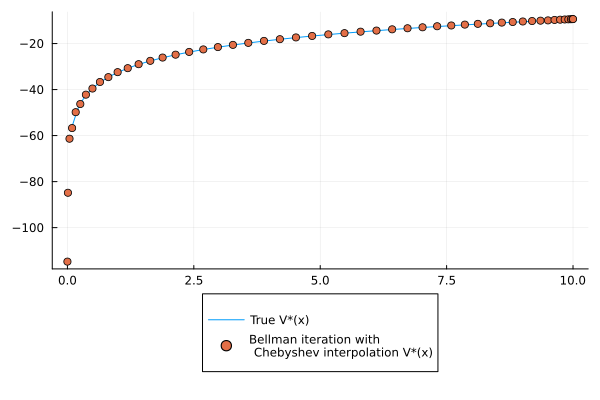

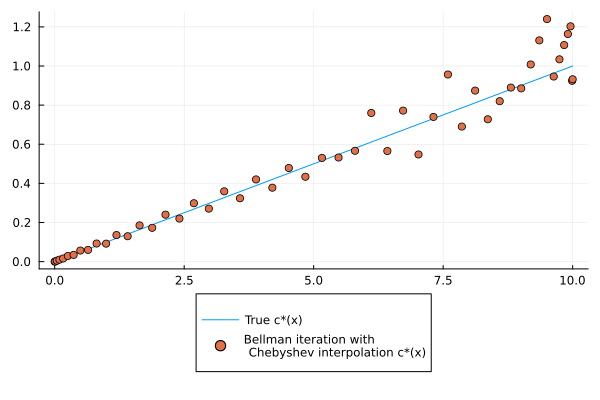

In [21]:
plot_grid = range(x_grid[1], x_grid[end], length=100) # Finer grid for plot

gr()
plot(plot_grid, V_true.(plot_grid), label = "True V*(x)", legend = :outerbottom)
display(plot!(scatter!(x_cheb_grid, v_cheb_interp, label = "Bellman iteration with \n Chebyshev interpolation V*(x)")))

gr()
plot(plot_grid, c_true.(plot_grid), label = "True c*(x)", legend = :outerbottom)
display(plot!(scatter!(x_cheb_grid, c_cheb_interp, label = "Bellman iteration with \n Chebyshev interpolation c*(x)")))

In [22]:
# RHS of the Bellman eq.
function Bellman_lin_interp(x_grid::Union{AbstractRange{Float64}, Vector{Float64}}, v_grid::Vector{Float64}; β = 0.9)
    # Input:
    # x_grid = range(xmin, xmax, length) : a grid for the x values
    # v_grid : the corresponding grid for V(x) values
    
    # Output:
    # v_next : the RHS of the Bellman eq. for each x on the grid
    # c_max : the policy function for each x on the grid corresponding to v_grid
    
    # Initialize empty vectors to store the results
    v_next = zero(v_grid)
    c_max = zero(v_grid)
    
    # Interpolate
    lin_int = LinearInterpolator(x_grid, v_grid)
    
    for (i, x) in enumerate(x_grid)
        opt = optimize(c -> -u(c+1e-5) -β*lin_int(x-c+1e-5), 0.0, x) 
        # Add small number to avoid log(0)
        # optimize does minimization, hence (-1)*objective
        c_max[i] = Optim.minimizer(opt)
        v_next[i] = -Optim.minimum(opt)
    end
    return v_next, c_max
end

# Solve Bellman eq. by iteration
function Bellman_iter_lin_interp(x_grid::Union{AbstractRange{Float64}, Vector{Float64}}; β = 0.9, tol = 1e-10)
    # Input:
    # x_grid = range(xmin, xmax, length) : a grid for the x values
    
    # Output:
    # v_star : the value function for each x on the grid
    # c_max : the policy function for each x on the grid
    
    # Initialize empty vectors to store the results
    v_grid = zero(x_grid)
    v_next = zero(x_grid)
    c_max = zero(x_grid)
    
    error = 1000.0

    while error > tol
        v_next, c_max = Bellman_lin_interp(x_grid, v_grid; β)
        error = maximum(abs.(v_next .- v_grid))
        v_grid = v_next
    end
    
    return v_next, c_max
end

x0 = 10

x_lin_grid = range(0, x0, 50)

v_lin_interp, c_lin_interp = Bellman_iter_lin_interp(x_lin_grid);

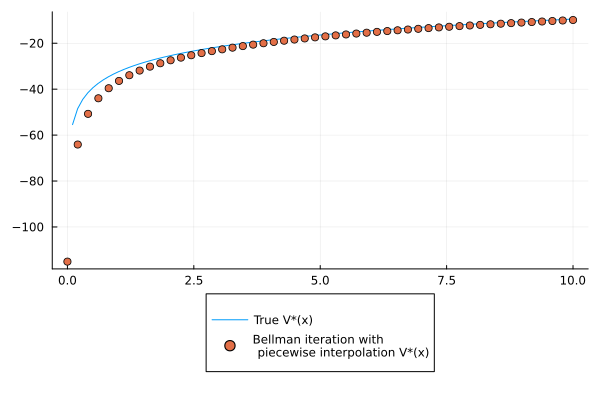

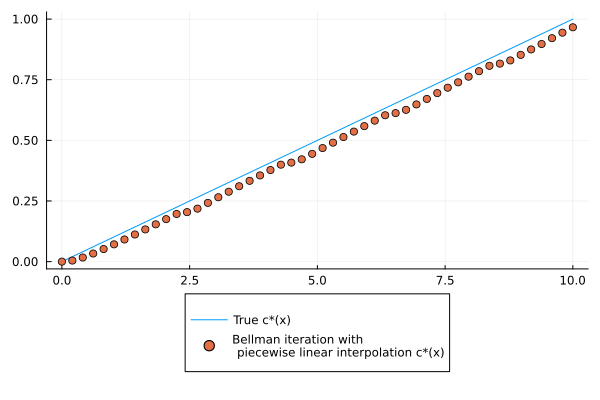

In [21]:
plot_grid = range(x_grid[1], x_grid[end], length=100) # Finer grid for plot

gr()
plot(plot_grid, V_true.(plot_grid), label = "True V*(x)", legend = :outerbottom)
display(plot!(scatter!(x_lin_grid, v_lin_interp, label = "Bellman iteration with \n piecewise interpolation V*(x)")))

gr()
plot(plot_grid, c_true.(plot_grid), label = "True c*(x)", legend = :outerbottom)
display(plot!(scatter!(x_lin_grid, c_lin_interp, label = "Bellman iteration with \n piecewise linear interpolation c*(x)")))

Notice: 
1. Using Chebyshev interpolation gives an almost perfect value function, but the policy function is not so good. My intuition for that is that the Chebyshev interpolation oscillates above and below the curve, and, while the true value function is strictly concave, the interpolated one has some local maxima and minima.
2. Using a piecewise linear approximation gives, again, surprisingly good results, except for small $x$, when $V(x)$ is far from linear. The policy function is much better, though; my intuition is that a piecewise linear interpolation preserves the concavity properties of the interpolated function, so optimizing the interpolated problem yields a maximizer that is closer to the true maximizer.

Finally, realize that the interpolation-based Bellman iteration is much faster than the grid-based method with 1000 grid points!

In [23]:
@time Bellman_iter(x_grid)
@time Bellman_iter_cheb_interp(x_cheb_grid);
@time Bellman_iter_lin_interp(x_lin_grid);

  1.475735 seconds (2.20 k allocations: 5.674 MiB, 0.39% gc time)
  0.033942 seconds (138.27 k allocations: 9.238 MiB, 1.39% gc time)
  0.013090 seconds (26.74 k allocations: 2.226 MiB)


### 3.1. Choosing the Grid
With most methods (except Chebyshev interpolation), you have some flexibility in how to choose the grid over which you approximate. Here are a couple of helpful heuristics:
1. Multi-grid algorithms: you could try first solving the problem on a coarse grid, and then using the solution as starting values for the problem on a finer grid.
2. Unevenly spaced grids: it could be helpful to have more gridpoints in regions where the value or policy functions have higher curvature. Again, to discover which regions have higher curvature, you can do a first pass on a coarser grid.

What if we try now a grid for the linear interpolation that is a bit finer on the lower part of the domain?

In [23]:
x_lin_grid2 = vcat(range(0, 0.99, 30), range(1.0, x0, 20)) # 30 grid points between 0 and .99, 20 between 1 and x0

v_lin_interp2, c_lin_interp2 = Bellman_iter_lin_interp(x_lin_grid2);

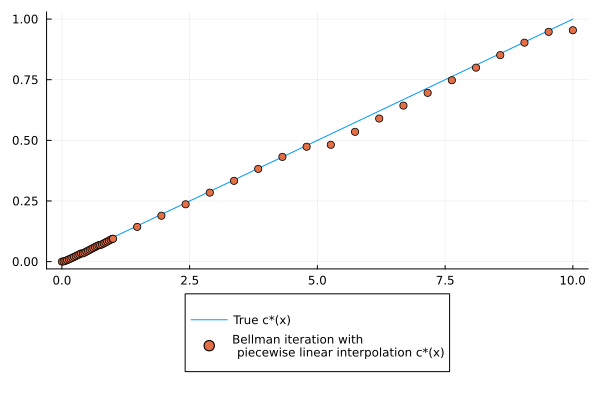

In [24]:
gr()
plot(plot_grid, V_true.(plot_grid), label = "True V*(x)", legend = :outerbottom)
display(plot!(scatter!(x_lin_grid2, v_lin_interp2, label = "Bellman iteration with \n piecewise interpolation V*(x)")))

gr()
plot(plot_grid, c_true.(plot_grid), label = "True c*(x)", legend = :outerbottom)
display(plot!(scatter!(x_lin_grid2, c_lin_interp2, label = "Bellman iteration with \n piecewise linear interpolation c*(x)")))

## 3.2. Assessing the Quality of the Interpolation: Euler Residuals
How do we know if our approximate, interpolated solution is good or not? How do we translate numerical error into an economically interpretable magnitude?

Let's introduce **Euler residuals**. The Euler equation for this problem is:
$$u'(c_t) = \beta V'(x_{t+1}) = \beta u'(c_{t+1})$$
(The first equality is the FOC for $c_t$, the second follows from the envelope Theorem). 

Given a policy function $c(x)$, we define the Euler residual as:
$$ER(x; c) = u'(c(x)) - \beta u'(c(x - c(x)))$$

One approach that is common in the macro literature is to report the average squared Euler residuals over a dense grid for the $x$. Let's compute it for our solutions below: 

In [25]:
function avg_sq_ER(x_finer_grid, x_base_grid, c_grid; β = 0.9)
    
    # We interpolate the c function linearly:
    lin_int = LinearInterpolator(x_base_grid, c_grid)
    
    # Remember that u(c) = log(c), so u'(c) = 1/c
    ER(x) = 1.0/lin_int(x) - β * 1.0/lin_int(x - lin_int(x))
    
    return sum(ER(x)^2 for x in x_finer_grid)./length(x_finer_grid)
end

x_finer_grid = range(0.1, x0, 500) # Start at 0.1 to avoid 1/0

@show avg_sq_ER(x_finer_grid, x_grid, c_grid)
@show avg_sq_ER(x_finer_grid, x_cheb_grid, c_cheb_interp)
@show avg_sq_ER(x_finer_grid, x_lin_grid, c_lin_interp)
@show avg_sq_ER(x_finer_grid, x_lin_grid2, c_lin_interp2);

avg_sq_ER(x_finer_grid, x_grid, c_grid) = 5.510180826148644
avg_sq_ER(x_finer_grid, x_cheb_grid, c_cheb_interp) = 0.27039216472087385
avg_sq_ER(x_finer_grid, x_lin_grid, c_lin_interp) = 9.014170311273235
avg_sq_ER(x_finer_grid, x_lin_grid2, c_lin_interp2) = 0.04352978026763181


In fact, the Chebyshev interpolator seems to be doing better than it really is. This is because, when $c(x) \approx 0$, $1/c(x)$ is very large, and it dominates the rest of points. If we leave out the $[0,1]$ range entirely, the results look more in line with the plots above:

In [26]:
x_finer_grid_2 = range(1, x0, 500)

@show avg_sq_ER(x_finer_grid_2, x_grid, c_grid)
@show avg_sq_ER(x_finer_grid_2, x_cheb_grid, c_cheb_interp)
@show avg_sq_ER(x_finer_grid_2, x_lin_grid, c_lin_interp)
@show avg_sq_ER(x_finer_grid_2, x_lin_grid2, c_lin_interp2);

avg_sq_ER(x_finer_grid_2, x_grid, c_grid) = 0.006519235112828478
avg_sq_ER(x_finer_grid_2, x_cheb_grid, c_cheb_interp) = 0.1189618901218596
avg_sq_ER(x_finer_grid_2, x_lin_grid, c_lin_interp) = 0.00317840739291747
avg_sq_ER(x_finer_grid_2, x_lin_grid2, c_lin_interp2) = 0.0014442232777195666


## 4. Policy Function Iteration

The methods we have considered so far iterate on the value function.

An alternative is **policy function iteration**:
1. Start with a guess $c^{(0)}(x)$.

2. At each iteration $k \geq 1$:
    1. Build the value function that would result if the policy $c^{(k-1)}(x)$ is followed:
    $$V^{(k-1)}(x) = \sum_{t=0}^T \beta^t u(c^{(k-1)}(x_t)), \qquad x_{t+1} = x_{t} - c^{(k)}(x_t) \quad t \geq 0,$$ for some large $T$.
    2. Update the policy function guess. As before, we cannot do that for every possible $x$, but we can do it over a grid $x_1, \ldots, x_n$:
    $$c^{(k)}(x_i) = \arg \max_{0 \leq c \leq x_i}\{u(c) + \beta V^{(k-1)}(x_i - c)\} \quad i = 1, \ldots, n$$
    and then we will interpolate the resulting policy function.


3. Iterate until convergence.

In [26]:
function V(x::Float64, c::BasicInterpolator; β = 0.9, T = 100)
    V = 0.0
    for t = 0:T
        V += β^t * u(c(x) + 1e-5) 
        x = max(x - c(x), 0.0)
    end
    return V
end

function policy_fun_iter(x_grid::AbstractRange{Float64}; β = 0.9, tol = 1e-10, T = 100)
    # Input:
    # x_grid = range(xmin, xmax, length) : a grid for the x values
    
    # Output:
    # v_star : the value function for each x on the grid
    # c_max : the policy function for each x on the grid
    
    # Initialize vectors to store the results
    c_max  = 0.5 * x_grid # Initial guess is a linear function
    c_next = zero(c_max)
    
    error = 1000.0

    while error > tol
        c_inter = LinearInterpolator(x_grid, c_max)
        VV(x) = V(x, c_inter)
        for (i, x) in enumerate(x_grid)
            opt = maximize(c -> u(c+1e-5) + β*VV(x-c), 0.0, x)
            c_next[i] = Optim.maximizer(opt)
        end
        error = maximum(abs.(c_next .- c_max))
        c_max = c_next
    end
    
    c_inter = LinearInterpolator(x_grid, c_max)
    VV = V.(x_grid, (c_inter, ))
    return VV, c_max
end

v_pol_iter, c_pol_iter = policy_fun_iter(x_lin_grid);

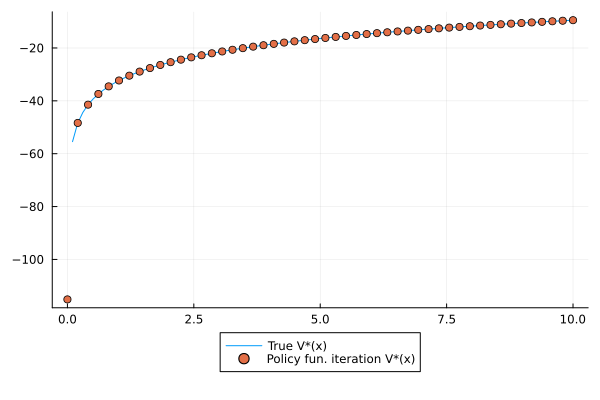

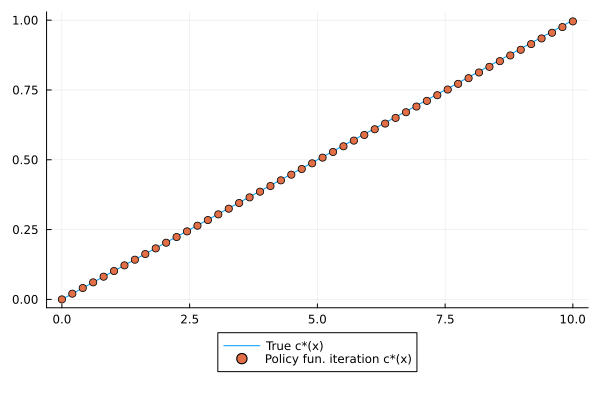

In [28]:
gr()
plot(plot_grid, V_true.(plot_grid), label = "True V*(x)", legend = :outerbottom)
display(plot!(scatter!(x_lin_grid, v_pol_iter, label = "Policy fun. iteration V*(x)")))

gr()
plot(plot_grid, c_true.(plot_grid), label = "True c*(x)", legend = :outerbottom)
display(plot!(scatter!(x_lin_grid, c_pol_iter, label = "Policy fun. iteration c*(x)")))

In [29]:
@time policy_fun_iter(x_lin_grid);

  0.016235 seconds (93.11 k allocations: 1.468 MiB)


In [30]:
@show avg_sq_ER(x_finer_grid, x_lin_grid, c_pol_iter);

avg_sq_ER(x_finer_grid, x_lin_grid, c_pol_iter) = 6.0009064868699856e-5


In this case, policy function iteration works extremely well (the fastest in some computers, and by far the most accurate method). One reason is that the true policy function _is_ linear, and so a linear interpolation achieves no error. Moreover, our initial guess $c(x)= 0.5x$ turns out to be a pretty good guess!

## Additional Resources
- Fedor Iskhakov's Foundations of Computational Economics course: lectures on [Cake Eating in Discrete World](https://github.com/fediskhakov/CompEcon/blob/main/30_cake_ongrid.ipynb), [Function Approximation (in Python)](https://github.com/fediskhakov/CompEcon/blob/main/31_approximation.ipynb), [Cake Eating Model with Discretized Choice](https://github.com/fediskhakov/CompEcon/blob/main/32_cake_discretized.ipynb), [Solving DP problems with policy iterations](https://github.com/fediskhakov/CompEcon/blob/main/43_policy_iter.ipynb).

- Judd (1998) Chapters 6 and 12, and references therein.

- [Other interpolation packages in Julia](https://github.com/JuliaMath/Interpolations.jl#other-interpolation-packages) from the documentation for ```Interpolations.jl```.

We won't cover the theory of dynamic programming here, as there is a whole course on DP in the 1st year Macro sequence (14.451). The canonical reference on DP is:
- Stokey, Nancy L., Lucas Jr., Robert E., and Edward C. Prescott (1989). *Recursive Methods in Economic Dynamics* Cambridge MA: Harvard University Press.